In [1]:
import os
from itertools import product
import config
import json
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import wandb
import util
import pandas as pd
import seaborn as sns
pd.set_option('display.max_colwidth', None)
import matplotlib.pyplot as plt
get_model_name = lambda dataset, model_type, curriculum: os.path.join(dataset + ("_" + model_type) + "_" + curriculum.split(".")[0])


In [2]:
experiments =[(get_model_name(dataset, model_type, curriculum), dataset, model_type, curriculum) for dataset, model_type, curriculum in product(config.datasets, config.model_types, config.baseline_curricula)]
experiments.extend([(get_model_name(dataset, model_type, model_type + curriculum), dataset, model_type, model_type + curriculum) for dataset, model_type, curriculum  in (product(config.datasets, config.model_types, config.influence_curricula))])
experiments_to_include = [os.path.basename(j[0]) for j in experiments]


In [3]:
import util
from tqdm import tqdm

In [4]:
cache_path = "./plotting_notebooks/cache/pretraining_metrics.pkl"


if not os.path.exists(cache_path):
    api = wandb.Api()


    project_path = "loriss/pretraining"

    metric_path="train/loss"
    runs = api.runs(project_path)


    data = []
    for run in tqdm(runs):
        train = run.history(keys=["train/loss"]).set_index("_step") 
        eval = run.history(keys=["eval/loss"]).set_index("_step")
        
        epoch = run.history(keys=["train/epoch"]).set_index("_step")
        epoch["model"] = run.name  
        data.append(epoch.join(train).join(eval) )
    df = pd.concat(data, ignore_index=True)


    df["dataset"] = df["model"].apply(util.get_dataset)
    df["curriculum"] = df["model"].apply(util.get_curriculum_name)
    df.to_pickle(cache_path)

else:
    print("Reusing cached results")

df = pd.read_pickle(cache_path)




Reusing cached results


In [5]:
# df = pd.read_csv(os.path.join("./plotting_notebooks/cache/","pretraining_metrics.csv"))

# print("not included in experiments but eval exists ", [model  for model in df["model"].unique() if not any([os.path.basename(model) == e for e in experiments_to_include])])
# print("to include in plots but eval doesn not exist ")
# t = [model  for model in experiments_to_include if  model not in [os.path.basename(mm) for mm in df["model"].unique()]]
# print(len(t), t)
# filter by experiments included in paper
df = df[df["model"].apply(lambda x: os.path.basename(x) in experiments_to_include)]

In [6]:
df

,train/epoch,model,train/loss,eval/loss,dataset,curriculum
0,0.086843,models/babylm_2024_10m_curriculum_llama_random,122.0504,NaN,babylm_2024_10m_curriculum,random.pt
1,0.173686,models/babylm_2024_10m_curriculum_llama_random,88.4017,NaN,babylm_2024_10m_curriculum,random.pt
2,0.260530,models/babylm_2024_10m_curriculum_llama_random,77.1281,NaN,babylm_2024_10m_curriculum,random.pt
3,0.347373,models/babylm_2024_10m_curriculum_llama_random,70.9591,NaN,babylm_2024_10m_curriculum,random.pt
4,0.434216,models/babylm_2024_10m_curriculum_llama_random,67.7829,NaN,babylm_2024_10m_curriculum,random.pt
...,...,...,...,...,...,...
7394,9.797895,models/stratified_10m_curriculum_roberta_roberta_incr_influence_epoch_repetition,1.9449,NaN,stratified_10m_curriculum,_incr_influence_epoch_repetition.pt
7395,9.893566,models/stratified_10m_curriculum_roberta_roberta_incr_influence_epoch_repetition,1.8900,NaN,stratified_10m_curriculum,_incr_influence_epoch_repetition.pt
7396,9.989237,models/stratified_10m_curriculum_roberta_roberta_incr_influence_epoch_repetition,1.8585,NaN,stratified_10m_curriculum,_incr_influence_epoch_repetition.pt
7397,9.998804,models/stratified_10m_curriculum_roberta_roberta_incr_influence_epoch_repetition,NaN,4.766241,stratified_10m_curriculum,_incr_influence_epoch_repetition.pt


In [7]:
import util

# for what models does evaluation loss incrase overall?
aa = df.groupby("model").filter(
    lambda group: (
        group_sorted := group.sort_values(by="train/epoch")
    )["eval/loss"].dropna().iloc[-1] >= group_sorted["eval/loss"].dropna().iloc[0] 
)["model"].unique()
[(util.rename(a), util.rename_dataset(a), "Llama" if "llama" in a else "RoBERTa") for a in aa]

[('$C_{rand}$', '$D_{2024}$', 'Llama'),
 ('$C_{A}$', '$D_{2024}$', 'Llama'),
 ('$C_{source}$', '$D_{2024}$', 'Llama'),
 ('$C_{rand}$', '$D_{stratified}$', 'Llama'),
 ('$C^E_{\\searrow}$', '$D_{stratified}$', 'Llama'),
 ('$C_{MATTR}$', '$D_{2024}$', 'Llama'),
 ('$C^{\\{50\\}}_{\\nearrow}$', '$D_{stratified}$', 'Llama'),
 ('$C^E_{\\nearrow}$', '$D_{2024}$', 'Llama'),
 ('$C^E_{\\nearrow}$', '$D_{2024}$', 'RoBERTa'),
 ('$C^E_{\\nearrow}$', '$D_{stratified}$', 'Llama')]

In [8]:
df["model_type"] = df["model"].apply(lambda x: "roberta" if "roberta" in x else "llama")

In [9]:
df.columns

Index(['train/epoch', 'model', 'train/loss', 'eval/loss', 'dataset',
       'curriculum', 'model_type'],
      dtype='object')

In [10]:
train_loss_ratios = []

for (model, dataset, curriculum), group in df.groupby(['model', 'dataset', 'curriculum']):
    group = group.sort_values(by="train/epoch",ascending=True)  
    group["current_min_train"] = group["train/loss"].expanding().min().shift(1)
    group["loss_ratio_train"] = group["train/loss"] / group["current_min_train"]

    train_loss_ratios.append(group[['model', 'dataset', 'curriculum',"train/epoch","loss_ratio_train"]])
 
df_train_loss_ratios = pd.DataFrame(pd.concat(train_loss_ratios,axis=0))
df_train_loss_ratios["model_type"] = df_train_loss_ratios["model"].apply(lambda x: "RoBERTa" if "roberta" in x else "Llama") 
df_train_loss_ratios["curriculum"] = df_train_loss_ratios["curriculum"].apply(util.rename)
df_train_loss_ratios["model"] = df_train_loss_ratios["model"].apply(util.rename_model)
df_train_loss_ratios["dataset"] = df_train_loss_ratios["dataset"].apply(util.rename_dataset)

In [11]:
df_max_loss = df_train_loss_ratios.loc[df_train_loss_ratios.groupby(['model', 'dataset', 'curriculum',"model_type"])['loss_ratio_train'].idxmax()]
df_mean_loss = df_train_loss_ratios.groupby(['model', 'dataset', 'curriculum',"model_type"])['loss_ratio_train'].mean()


In [ ]:
df_count_above_1_2 = df_train_loss_ratios[df_train_loss_ratios['loss_ratio_train'] > 1.2].groupby(['model', 'dataset', 'curriculum',"model_type"]).size().reset_index(name='count_above_1.2')
df_count_above_1_2 

,model,dataset,curriculum,count_above_1.2
0,$(C*h)^{\sim}_{\nearrow}$,$D_{2024}$,$(C*h)^{\sim}_{\nearrow}$,183
1,$(C*h)^{\sim}_{\nearrow}$,$D_{stratified}$,$(C*h)^{\sim}_{\nearrow}$,123
2,$(C*h)^{\sim}_{\searrow}$,$D_{2024}$,$(C*h)^{\sim}_{\searrow}$,185
3,$(C*h)^{\sim}_{\searrow}$,$D_{stratified}$,$(C*h)^{\sim}_{\searrow}$,119
4,$C^E_{\nearrow}$,$D_{2024}$,$C^E_{\nearrow}$,72
5,$C^E_{\nearrow}$,$D_{stratified}$,$C^E_{\nearrow}$,65
6,$C^E_{\searrow}$,$D_{2024}$,$C^E_{\searrow}$,119
7,$C^E_{\searrow}$,$D_{stratified}$,$C^E_{\searrow}$,67
8,$C^{\sim}_{\nearrow}$,$D_{2024}$,$C^{\sim}_{\nearrow}$,183
9,$C^{\sim}_{\nearrow}$,$D_{stratified}$,$C^{\sim}_{\nearrow}$,132


In [13]:
df_token_counts = pd.read_pickle((os.path.join("./plotting_notebooks/cache/","curricula_metrics_counts.pkl")))
df_token_counts["tokens seen by model"] = df_token_counts["tokens seen by model"].apply(lambda x: [np.mean(a) for a in np.array_split(x,1000)])
for (model, dataset, curriculum), group in df.groupby(['model', 'dataset', 'curriculum',"model_type"]):
    measurements = df_token_counts[
        (df_token_counts["dataset"].apply(util.rename_dataset) == util.rename_dataset(dataset)) &
        (df_token_counts["model_type"] == ("roberta" if "roberta" in model else "llama")) &
        (df_token_counts["curriculum"].apply(util.rename) == util.rename(curriculum))
    ].iloc[0]["tokens seen by model"]
    
    for t in group["train/epoch"]:

        idx = round(t / 10 * (len(measurements) - 1))
      

        df.loc[df["train/epoch"] == t, "mean tokens per document"] = measurements[idx]


In [ ]:
df_max_loss

,model,dataset,curriculum,train/epoch,loss_ratio_train,model_type
392,$(C*h)^{\sim}_{\nearrow}$,$D_{2024}$,$(C*h)^{\sim}_{\nearrow}$,1.217108,1.950629e+07,Llama
4247,$(C*h)^{\sim}_{\nearrow}$,$D_{2024}$,$(C*h)^{\sim}_{\nearrow}$,8.260530,1.520013e+05,RoBERTa
1790,$(C*h)^{\sim}_{\nearrow}$,$D_{equitoken}$,$(C*h)^{\sim}_{\nearrow}$,5.102302,9.440120e-01,Llama
5212,$(C*h)^{\sim}_{\nearrow}$,$D_{equitoken}$,$(C*h)^{\sim}_{\nearrow}$,9.184143,9.574647e-01,RoBERTa
2724,$(C*h)^{\sim}_{\nearrow}$,$D_{stratified}$,$(C*h)^{\sim}_{\nearrow}$,8.237264,1.395416e+00,Llama
...,...,...,...,...,...,...
4798,$C_{source}$,$D_{2024}$,$C_{source}$,2.086843,2.496741e+00,RoBERTa
2232,$C_{source}$,$D_{equitoken}$,$C_{source}$,9.184143,1.440375e+00,Llama
5378,$C_{source}$,$D_{equitoken}$,$C_{source}$,9.184143,1.060979e+00,RoBERTa
3278,$C_{source}$,$D_{stratified}$,$C_{source}$,8.091844,6.412391e+00,Llama


In [ ]:
 (
    df_max_loss
    .groupby(["dataset", "curriculum"])["loss_ratio_train"]
    .mean()
    .reset_index()
    .sort_values(by=["dataset", "loss_ratio_train"], ascending=[True, True])
)


,dataset,curriculum,loss_ratio_train
12,$D_{2024}$,$C_{rand}$,1.041295e+00
6,$D_{2024}$,$C^{\{50\}}_{\nearrow}$,1.214308e+00
9,$D_{2024}$,$C_{MATTR}$,2.430939e+00
8,$D_{2024}$,$C_{A}$,2.904346e+00
2,$D_{2024}$,$C^E_{\nearrow}$,3.252513e+00
3,$D_{2024}$,$C^E_{\searrow}$,5.470743e+00
13,$D_{2024}$,$C_{source}$,1.072705e+01
5,$D_{2024}$,$C^{\sim}_{\searrow}$,1.974772e+05
11,$D_{2024}$,$C_{\searrow}$,5.024112e+05
1,$D_{2024}$,$(C*h)^{\sim}_{\searrow}$,2.270752e+06


In [ ]:
df_max_loss

,model,dataset,curriculum,train/epoch,loss_ratio_train,model_type
392,$(C*h)^{\sim}_{\nearrow}$,$D_{2024}$,$(C*h)^{\sim}_{\nearrow}$,1.217108,1.950629e+07,Llama
5212,$(C*h)^{\sim}_{\nearrow}$,$D_{equitoken}$,$(C*h)^{\sim}_{\nearrow}$,9.184143,9.574647e-01,RoBERTa
6371,$(C*h)^{\sim}_{\nearrow}$,$D_{stratified}$,$(C*h)^{\sim}_{\nearrow}$,9.290840,2.427401e+04,RoBERTa
577,$(C*h)^{\sim}_{\searrow}$,$D_{2024}$,$(C*h)^{\sim}_{\searrow}$,5.998697,2.270752e+06,Llama
5220,$(C*h)^{\sim}_{\searrow}$,$D_{equitoken}$,$(C*h)^{\sim}_{\searrow}$,3.061381,9.571830e-01,RoBERTa
6481,$(C*h)^{\sim}_{\searrow}$,$D_{stratified}$,$(C*h)^{\sim}_{\searrow}$,8.906960,5.682019e+06,RoBERTa
6968,$C^E_{\nearrow}$,$D_{2024}$,$C^E_{\nearrow}$,4.132002,3.252513e+00,Llama
7060,$C^E_{\nearrow}$,$D_{equitoken}$,$C^E_{\nearrow}$,9.184143,9.669334e-01,Llama
7251,$C^E_{\nearrow}$,$D_{stratified}$,$C^E_{\nearrow}$,6.089931,5.768827e+00,Llama
1686,$C^E_{\searrow}$,$D_{2024}$,$C^E_{\searrow}$,6.086843,5.470743e+00,Llama


,model,dataset,curriculum,train/epoch,loss_ratio_train,model_type
392,$(C*h)^{\sim}_{\nearrow}$,$D_{2024}$,$(C*h)^{\sim}_{\nearrow}$,1.217108,1.950629e+07,Llama
577,$(C*h)^{\sim}_{\searrow}$,$D_{2024}$,$(C*h)^{\sim}_{\searrow}$,5.998697,2.270752e+06,Llama
6968,$C^E_{\nearrow}$,$D_{2024}$,$C^E_{\nearrow}$,4.132002,3.252513e+00,Llama
1686,$C^E_{\searrow}$,$D_{2024}$,$C^E_{\searrow}$,6.086843,5.470743e+00,Llama
215,$C^{\sim}_{\nearrow}$,$D_{2024}$,$C^{\sim}_{\nearrow}$,7.217108,2.249727e+09,Llama
287,$C^{\sim}_{\searrow}$,$D_{2024}$,$C^{\sim}_{\searrow}$,2.955276,1.974772e+05,Llama
1234,$C^{\{50\}}_{\nearrow}$,$D_{2024}$,$C^{\{50\}}_{\nearrow}$,8.086843,1.214308e+00,Llama
719,$C_\nearrow$,$D_{2024}$,$C_\nearrow$,7.217108,4.033686e+10,Llama
791,$C_{\searrow}$,$D_{2024}$,$C_{\searrow}$,2.955276,5.024112e+05,Llama
73,$C_{rand}$,$D_{2024}$,$C_{rand}$,5.998697,1.041295e+00,Llama


/tmp/ipykernel_3266146/3688009615.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mean_loss.index, y=mean_loss.values, palette=palette)


('$D_{2024}$', 'Llama')


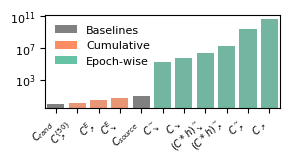

,model,dataset,curriculum,train/epoch,loss_ratio_train,model_type
4705,$C_{A}$,$D_{2024}$,$C_{A}$,4.781589,2.904346e+00,RoBERTa
4911,$C_{MATTR}$,$D_{2024}$,$C_{MATTR}$,3.998697,2.430939e+00,RoBERTa
5260,$C_{PPL}$,$D_{2024}$,$C_{PPL}$,2.086843,2.228114e+17,RoBERTa


('$D_{2024}$', 'RoBERTa')


/tmp/ipykernel_3266146/3688009615.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mean_loss.index, y=mean_loss.values, palette=palette)


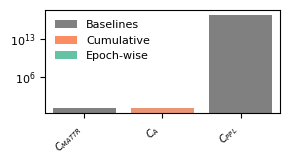

,model,dataset,curriculum,train/epoch,loss_ratio_train,model_type
7060,$C^E_{\nearrow}$,$D_{equitoken}$,$C^E_{\nearrow}$,9.184143,0.966933,Llama
1738,$C^E_{\searrow}$,$D_{equitoken}$,$C^E_{\searrow}$,9.184143,1.043603,Llama
2232,$C_{source}$,$D_{equitoken}$,$C_{source}$,9.184143,1.440375,Llama


/tmp/ipykernel_3266146/3688009615.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mean_loss.index, y=mean_loss.values, palette=palette)


('$D_{equitoken}$', 'Llama')


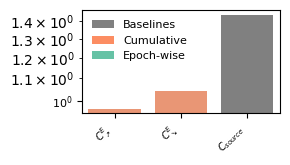

,model,dataset,curriculum,train/epoch,loss_ratio_train,model_type
5212,$(C*h)^{\sim}_{\nearrow}$,$D_{equitoken}$,$(C*h)^{\sim}_{\nearrow}$,9.184143,0.957465,RoBERTa
5220,$(C*h)^{\sim}_{\searrow}$,$D_{equitoken}$,$(C*h)^{\sim}_{\searrow}$,3.061381,0.957183,RoBERTa
5172,$C^{\sim}_{\nearrow}$,$D_{equitoken}$,$C^{\sim}_{\nearrow}$,9.184143,0.957123,RoBERTa
5180,$C^{\sim}_{\searrow}$,$D_{equitoken}$,$C^{\sim}_{\searrow}$,3.061381,0.955971,RoBERTa
5565,$C^{\{50\}}_{\nearrow}$,$D_{equitoken}$,$C^{\{50\}}_{\nearrow}$,9.184143,0.957158,RoBERTa
5513,$C_\nearrow$,$D_{equitoken}$,$C_\nearrow$,3.061381,0.959437,RoBERTa
5688,$C_{A}$,$D_{equitoken}$,$C_{A}$,3.061381,0.957239,RoBERTa
5386,$C_{MATTR}$,$D_{equitoken}$,$C_{MATTR}$,3.061381,0.957485,RoBERTa
5408,$C_{PPL}$,$D_{equitoken}$,$C_{PPL}$,4.081841,0.963278,RoBERTa
5533,$C_{\searrow}$,$D_{equitoken}$,$C_{\searrow}$,3.061381,0.958344,RoBERTa


/tmp/ipykernel_3266146/3688009615.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mean_loss.index, y=mean_loss.values, palette=palette)


('$D_{equitoken}$', 'RoBERTa')


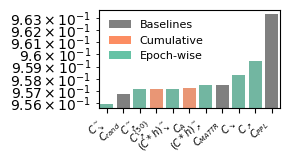

,model,dataset,curriculum,train/epoch,loss_ratio_train,model_type
7251,$C^E_{\nearrow}$,$D_{stratified}$,$C^E_{\nearrow}$,6.089931,5.768827e+00,Llama
1975,$C^E_{\searrow}$,$D_{stratified}$,$C^E_{\searrow}$,9.130112,6.733337e+00,Llama
2125,$C^{\sim}_{\nearrow}$,$D_{stratified}$,$C^{\sim}_{\nearrow}$,1.149247,3.795682e+02,Llama
2180,$C^{\sim}_{\searrow}$,$D_{stratified}$,$C^{\sim}_{\searrow}$,2.968189,1.543040e+10,Llama
3059,$C^{\{50\}}_{\nearrow}$,$D_{stratified}$,$C^{\{50\}}_{\nearrow}$,7.424779,1.165429e+00,Llama
3194,$C_{A}$,$D_{stratified}$,$C_{A}$,9.195169,1.722156e+00,Llama
1574,$C_{rand}$,$D_{stratified}$,$C_{rand}$,6.991150,1.040648e+00,Llama
3278,$C_{source}$,$D_{stratified}$,$C_{source}$,8.091844,6.412391e+00,Llama


/tmp/ipykernel_3266146/3688009615.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mean_loss.index, y=mean_loss.values, palette=palette)


('$D_{stratified}$', 'Llama')


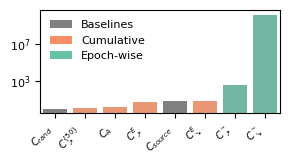

,model,dataset,curriculum,train/epoch,loss_ratio_train,model_type
6371,$(C*h)^{\sim}_{\nearrow}$,$D_{stratified}$,$(C*h)^{\sim}_{\nearrow}$,9.290840,2.427401e+04,RoBERTa
6481,$(C*h)^{\sim}_{\searrow}$,$D_{stratified}$,$(C*h)^{\sim}_{\searrow}$,8.906960,5.682019e+06,RoBERTa
6553,$C_\nearrow$,$D_{stratified}$,$C_\nearrow$,5.076537,3.891686e+03,RoBERTa
5680,$C_{MATTR}$,$D_{stratified}$,$C_{MATTR}$,9.960536,1.691088e+00,RoBERTa
5772,$C_{PPL}$,$D_{stratified}$,$C_{PPL}$,6.130112,1.765034e+17,RoBERTa
6634,$C_{\searrow}$,$D_{stratified}$,$C_{\searrow}$,2.107151,3.345278e+03,RoBERTa


('$D_{stratified}$', 'RoBERTa')


/tmp/ipykernel_3266146/3688009615.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mean_loss.index, y=mean_loss.values, palette=palette)


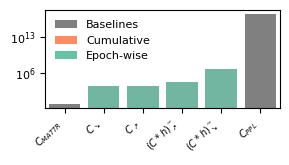

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

for name, daf in df_max_loss.groupby(["dataset","model_type"]):
    display(daf)
    mean_loss = daf.groupby("curriculum")["loss_ratio_train"].mean().sort_values()

    set2 = sns.color_palette("Set2")

    palette = []
    for c in mean_loss.index:
        if c in [util.rename(b) for b in config.baseline_curricula]:
            palette.append("gray")
        elif c in [util.rename(x) for x in config.influence_curricula if ("epoch" in x) or ("50" in x) or ("sand" in x)]:
            palette.append(set2[1])
        else:
            palette.append(set2[0])


    plt.figure(figsize=(3, 1.75))
    sns.barplot(x=mean_loss.index, y=mean_loss.values, palette=palette)

    from matplotlib.patches import Patch

    plt.yscale("log")
    legend_elements = [
        Patch(facecolor="gray", label="Baselines"),
        Patch(facecolor=set2[1], label="Cumulative"),
        Patch(facecolor=set2[0], label="Epoch-wise")
    ]
    plt.legend(handles=legend_elements, loc="upper left", fontsize=8, frameon=False)


    plt.xticks(rotation=45, ha="right", fontsize=7)
    plt.yticks(fontsize=8)
    plt.xlabel("", fontsize=8)
    plt.title("", fontsize=8)


    plt.tight_layout()
    plt.savefig("./autogenerated_figures/loss_ratio_barplot_"+name[1] +"_"+ name[0].replace("$","").replace("{","").replace("}","")+".pdf", bbox_inches='tight')
    print(name)
    plt.show()


In [ ]:
benchmark_results = pd.read_pickle("./plotting_notebooks/cache/benchmark_results.pkl")


In [ ]:
dff = benchmark_results.merge(df_max_loss,left_on=["model","dataset","curriculum"], right_on=["model","dataset","curriculum"])


In [ ]:
dff

,model,model_acc,random_acc,p_value,average_improvement,significant,average_improvement_source_difficulty,formatted_improvement,dataset,curriculum,model_type_x,train/epoch,loss_ratio_train,model_type_y
0,$C^E_{\nearrow}$,0.486742,0.630457,9.813635e-06,-14.371556,True,-13.158646,-14.37\%***,$D_{equitoken}$,$C^E_{\nearrow}$,Llama,9.184143,9.669334e-01,Llama
1,$C^E_{\nearrow}$,0.527150,0.631135,3.183010e-06,-10.398497,True,-9.488725,-10.40\%***,$D_{2024}$,$C^E_{\nearrow}$,Llama,4.132002,3.252513e+00,Llama
2,$C^E_{\nearrow}$,0.564281,0.644914,3.208876e-10,-8.063287,True,-2.493422,-8.06\%***,$D_{stratified}$,$C^E_{\nearrow}$,Llama,6.089931,5.768827e+00,Llama
3,$C^E_{\searrow}$,0.586505,0.644914,5.841027e-07,-5.840890,True,-0.271025,-5.84\%***,$D_{stratified}$,$C^E_{\searrow}$,Llama,9.130112,6.733337e+00,Llama
4,$C^E_{\searrow}$,0.574261,0.630457,4.005967e-05,-5.619637,True,-4.406727,-5.62\%***,$D_{equitoken}$,$C^E_{\searrow}$,Llama,9.184143,1.043603e+00,Llama
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,$C_{A}$,0.566731,0.496967,1.017621e-02,6.976413,True,-0.375249,+6.98\%**,$D_{2024}$,$C_{A}$,RoBERTa,4.781589,2.904346e+00,RoBERTa
80,$C_{MATTR}$,0.570238,0.496967,7.654461e-03,7.327153,True,-0.024509,+7.33\%***,$D_{2024}$,$C_{MATTR}$,RoBERTa,3.998697,2.430939e+00,RoBERTa
81,$C_{source}$,0.570484,0.496967,7.693906e-03,7.351662,True,0.000000,+7.35\%***,$D_{2024}$,$C_{source}$,RoBERTa,8.066001,1.072705e+01,Llama
82,$C^{\{50\}}_{\nearrow}$,0.574034,0.496967,4.997527e-03,7.706720,True,0.355058,+7.71\%***,$D_{2024}$,$C^{\{50\}}_{\nearrow}$,RoBERTa,8.086843,1.214308e+00,Llama


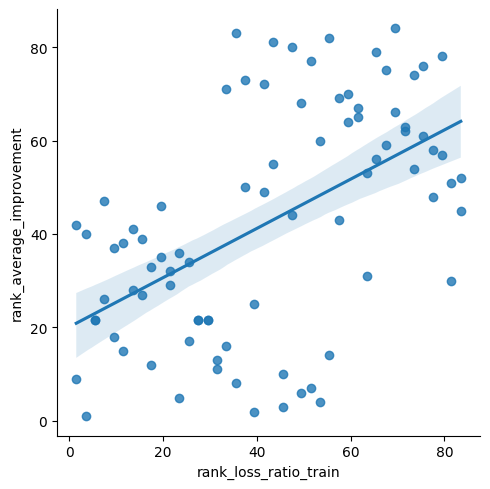

SignificanceResult(statistic=0.5269645455876927, pvalue=0.9999998693927344)
$D_{2024}$: Spearman correlation = 0.258, p-value = 0.185
$D_{equitoken}$: Spearman correlation = -0.128, p-value = 0.515
$D_{stratified}$: Spearman correlation = 0.106, p-value = 0.590


<Figure size 800x600 with 0 Axes>

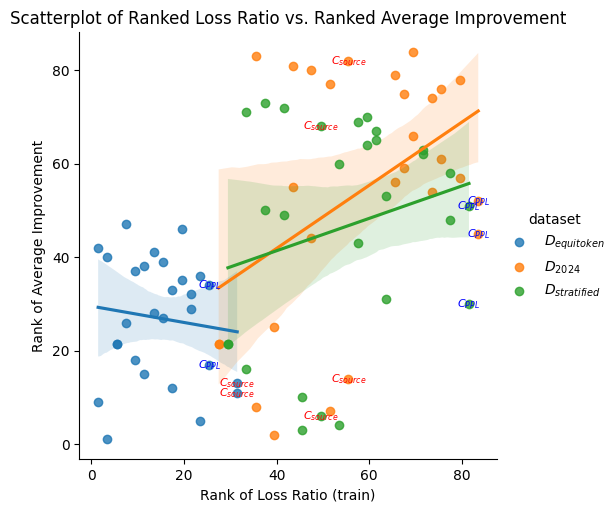

False: Spearman correlation = 0.262, p-value = 0.051


<Figure size 800x600 with 0 Axes>

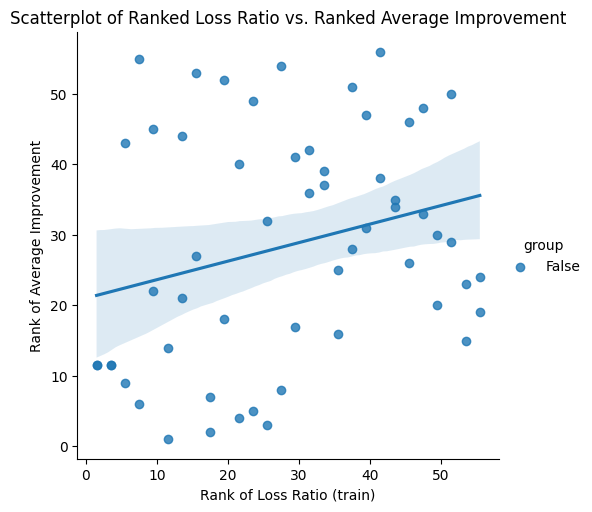

True: Spearman correlation = -0.128, p-value = 0.515


<Figure size 800x600 with 0 Axes>

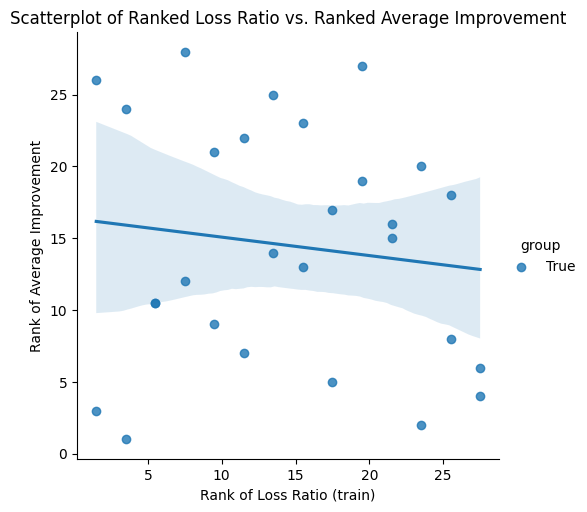

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd


dff = benchmark_results.merge(df_mean_loss, left_on=["model", "dataset", "curriculum"], right_on=["model", "dataset", "curriculum"])


dff['rank_loss_ratio_train'] = dff['loss_ratio_train'].rank()
dff['rank_average_improvement'] = dff['average_improvement'].rank()
sns.lmplot(
    x='rank_loss_ratio_train',
    y='rank_average_improvement',
 
    data=dff,
    scatter=True,
    fit_reg=True
)
plt.show()
print(stats.spearmanr(dff['loss_ratio_train'], dff['average_improvement'],alternative="less"))

for dataset, group in dff.groupby('dataset'):
    group['rank_loss_ratio_train'] = group['loss_ratio_train'].rank()
    group['rank_average_improvement'] = group['average_improvement'].rank()
    corr, pval = stats.spearmanr(group['loss_ratio_train'], group['average_improvement'])
    print(f"{dataset}: Spearman correlation = {corr:.3f}, p-value = {pval:.3f}")



plt.figure(figsize=(8, 6))
sns.lmplot(
    x='rank_loss_ratio_train',
    y='rank_average_improvement',
    hue='dataset',
    data=dff,
    scatter=True,
    fit_reg=True
)

for i, row in dff[dff['curriculum'] == "$C_{source}$"].iterrows():
    plt.text(
        row['rank_loss_ratio_train'], row['rank_average_improvement'],
        f"{row['curriculum']}", 
        horizontalalignment='center', verticalalignment='center',
        fontsize=8, color='red', weight='bold'
    )
for i, row in dff[dff['curriculum'] == "$C_{PPL}$"].iterrows():
    plt.text(
        row['rank_loss_ratio_train'], row['rank_average_improvement'],
        f"{row['curriculum']}", 
        horizontalalignment='center', verticalalignment='center',
        fontsize=8, color='blue', weight='bold'
    )
plt.title("Scatterplot of Ranked Loss Ratio vs. Ranked Average Improvement")
plt.xlabel("Rank of Loss Ratio (train)")
plt.ylabel("Rank of Average Improvement")
plt.show()






dff["group"] = dff["dataset"] == ("$D_{equitoken}$")
for dataset, group in dff.groupby('group'):
    group['rank_loss_ratio_train'] = group['loss_ratio_train'].rank()
    group['rank_average_improvement'] = group['average_improvement'].rank()
    corr, pval = stats.spearmanr(group['loss_ratio_train'], group['average_improvement'])
    print(f"{dataset}: Spearman correlation = {corr:.3f}, p-value = {pval:.3f}")



    plt.figure(figsize=(8, 6))
    sns.lmplot(
        x='rank_loss_ratio_train',
        y='rank_average_improvement',
        hue='group',
        data=group,
        scatter=True,
        fit_reg=True
    )
    plt.title("Scatterplot of Ranked Loss Ratio vs. Ranked Average Improvement")
    plt.xlabel("Rank of Loss Ratio (train)")
    plt.ylabel("Rank of Average Improvement")
    plt.show()




In [ ]:
data

NameError: name 'data' is not defined

KeyError: 'train/loss'

<Figure size 200x500 with 0 Axes>

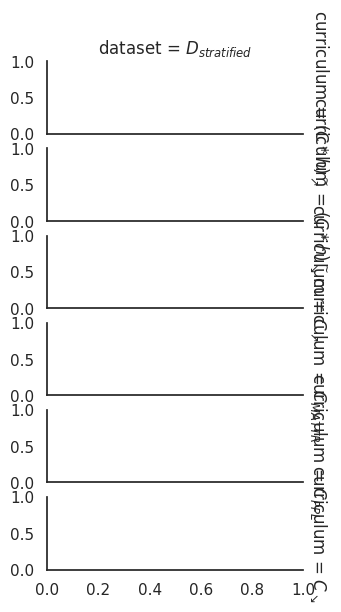

In [ ]:
WIDTH_TWO_COL = 2
FONT_SIZE = 10


import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="seaborn.axisgrid")
warnings.filterwarnings("ignore", category=UserWarning)

def plot(metric_path="train/loss"):
    plt.figure(figsize=(WIDTH_TWO_COL, 5))
    sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
    g = sns.FacetGrid(df, row="curriculum", hue="model_type",col="dataset", aspect=3, height=1.1, sharey=False, sharex=True,margin_titles=True)
    def facetgrid_two_axes(data, x_name, y1_name, y2_name, ylabel1, ylabel2,color=None,label=None):
        ax1 = plt.gca()
        sns.lineplot(x=data[data["model_type"] == "roberta"][x_name], y=data[data["model_type"] == "roberta"][y1_name], alpha=.7, ax=ax1,color="teal")
        ax1.set_ylabel("roberta",fontsize=10)
        if "train/loss" in metric_path:
            ax1.set_ylim(0,10)
        else:
            ax1.set_ylim(2,15)

       
        if "babylm_2024_10m_curriculum" == data.iloc[0]["dataset"]:
            ax1.set_ylabel("roberta", fontsize=10)
        else:
            ax1.set_ylabel("", fontsize=10)
            ax1.set_yticks([])


        ax2 = ax1.twinx()
        sns.lineplot(x=data[data["model_type"] == "llama"][x_name], y=data[data["model_type"] == "llama"][y1_name], alpha=.7, ax=ax2, color="orange")
        if "stratified_10m_curriculum" == data.iloc[0]["dataset"]:
            ax2.set_ylabel("llama", fontsize=10)
        else:
            ax2.set_ylabel("", fontsize=10)
            ax2.set_yticks([])

        if "train/loss" in metric_path:
            ax2.set_ylim(0,100)
        else:
            ax2.set_ylim(2,15)

    g.map_dataframe(facetgrid_two_axes, x_name="train/epoch", y1_name=metric_path, y2_name=metric_path, ylabel1="roberta", ylabel2="llama")
    # g.map(sns.lineplot, "train/epoch", metric_path, linewidth=2,marker="o")
    def label(x, color, label):
        ax = plt.gca()
        ax.text((WIDTH_TWO_COL/3)-0.3, 0.95, util.rename(x.iloc[0]), fontweight="bold", color="black", fontsize=FONT_SIZE+4,
                ha="left", va="center", transform=ax.transAxes,
                bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.1',alpha=0.6))

        ax.set_xlim(0,)
    g.map(label, "model")
    g.set_titles("{col_name}","", size=12)
    # g.set_axis_labels( "Epoch","",)
    g.set_axis_labels("Epoch", None)
    g.despine(left=True)
    g.figure.subplots_adjust(hspace=0.4, wspace=0.05)    
    for ax in g.axes.flat:
        title = ax.get_title()
        ax.set_title(title.replace("_10m_curriculum",""), fontsize=12,pad=20,fontweight="bold")
        ax.tick_params(labelsize=11)
    handles = [
        plt.Line2D([0], [0], color="teal", lw=2, label="RoBERTa",alpha=.7),
        plt.Line2D([0], [0], color="orange", lw=2, label="Llama",alpha=.7),
    ]
    g.fig.legend(handles=handles, loc="upper center", ncol=2, fontsize=11, bbox_to_anchor=(0.5, 0.95),facecolor='white')


    util.save_pdf(g, metric_path.replace('/', '_'))
    plt.show()
import util




plot("train/loss")
plot("eval/loss")

{'random.pt': (0.4, 0.7607843137254902, 0.6470588235294118), 'source_difficulty.pt': (0.9882352941176471, 0.5529411764705883, 0.3843137254901961), 'perplexity_increasing.pt': (0.5529411764705883, 0.6274509803921569, 0.796078431372549), 'mattr_increasing.pt': (0.9058823529411765, 0.5411764705882353, 0.7647058823529411), '_influence_incr_cp_dirac.pt': (0.6509803921568628, 0.8470588235294118, 0.32941176470588235), '_influence_decr_cp_dirac.pt': (1.0, 0.8509803921568627, 0.1843137254901961), '_influence_epoch_repetition.pt': (0.8980392156862745, 0.7686274509803922, 0.5803921568627451), '_influence_top_50_cp_shuffled.pt': (0.7019607843137254, 0.7019607843137254, 0.7019607843137254), '_influence_tracin_sandwich.pt': (0.7019607843137254, 0.7019607843137254, 0.7019607843137254), '_incr_influence_epoch_repetition.pt': (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)}
babylm_2024_10m_curriculum
babylm_2024_10m_curriculum
babylm_2024_10m_curriculum
babylm_2024_10m_curriculum
babylm_20

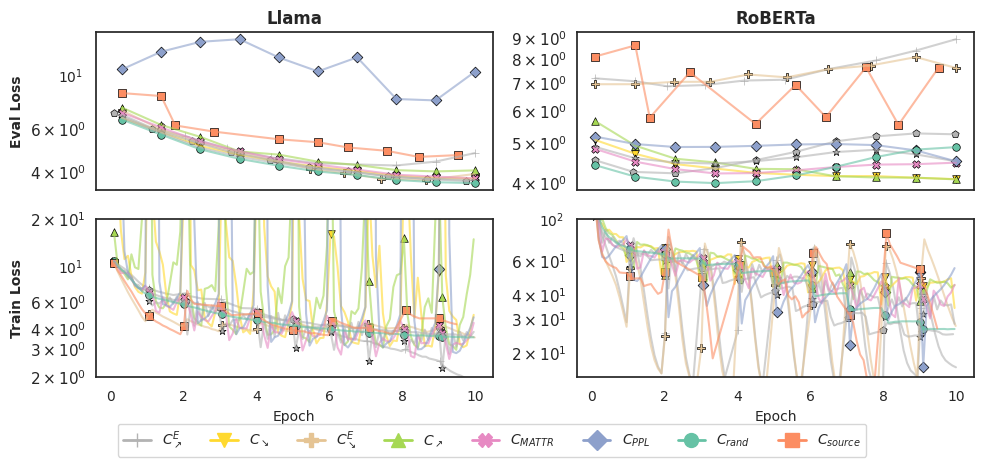

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import os
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D

warnings.filterwarnings("ignore", category=UserWarning, module="seaborn.axisgrid")
warnings.filterwarnings("ignore", category=UserWarning)

WIDTH_TWO_COL = 2
FONT_SIZE = 10

metric_paths = ["eval/loss", "train/loss"]
fig, axes = plt.subplots(2, 2, figsize=(WIDTH_TWO_COL * 5, 5))
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})





curriculum_markers = {
    "random.pt": "o",
    "source_difficulty.pt": "s",
    "perplexity_increasing.pt": "D",
    "mattr_increasing.pt": "X",
    "_influence_incr_cp_dirac.pt": "^",
    "_influence_decr_cp_dirac.pt": "v",
   "_influence_epoch_repetition.pt": "P",
    "_influence_top_50_cp_shuffled.pt": "p",
    "_influence_tracin_sandwich.pt": "*",
    "_incr_influence_epoch_repetition.pt": "+",
}
set1_colors = plt.cm.Set2(range(len(curriculum_markers.keys())))


curriculum_colors = {key: tuple(set1_colors[i][:3]) for i,key in enumerate(curriculum_markers.keys())}
print(curriculum_colors)

handles = []
labels = []
added_colors = set()

# Looping through the DataFrame and plotting
for (model, dataset, curriculum), group in df.groupby(["model_type", "dataset", "curriculum"]):
    if dataset != "stratified_10m_curriculum":
        print(dataset)
        continue

    if curriculum in curriculum_markers:
        color = curriculum_colors[curriculum]
        marker = curriculum_markers[curriculum]
    # elif curriculum in config.influence_curricula:

    #     color = "magenta" if curriculum  in ["_influence_epoch_repetition.pt", "_influence_tracin_sandwich.pt", "_influence_top_50_cp_shuffled.pt"] else "gray"
    #     marker = "P" if curriculum  in ["_influence_epoch_repetition.pt", "_influence_tracin_sandwich.pt", "_influence_top_50_cp_shuffled.pt"] else "x"
    #     print(curriculum,marker,color)
    else:
        print(f"Skipping unknown curriculum: {curriculum}")
        marker = "x"
        continue

    for col_idx, metric_path in enumerate(metric_paths):
        if metric_path not in group.columns:
            continue

        # Transposed indexing: Change row/col roles for the transpose
        col_idx_transposed = 0 if model == "roberta" else 1
        row_idx_transposed = 0 if metric_path == "eval/loss" else 1

        ax = axes[row_idx_transposed, col_idx_transposed]
        label = f"{model} - {curriculum}"
        
        sns.lineplot(
            data=group,
            x="train/epoch",
            y=metric_path,
            ax=ax,
            color=color,
            label=label,
            alpha=0.6,
            linewidth=1.5
        )

        sns.scatterplot(
            data=(group[group["train/epoch"].apply(lambda x : (x-int(x) < 1))]) if "eval" in metric_path else group[group["train/epoch"].apply(lambda x : (x-int(x) < 0.1))],
            x="train/epoch",
            y=metric_path,
            ax=ax,
            color=color,
            marker=marker,
            s=30,
            edgecolor='black',
            linewidth=0.5,
            legend=False
        )

        # Add custom marker to the legend if not already added
        if color not in added_colors:
            handles.append(Line2D([0], [0], color=color, lw=2, marker=marker, markersize=10, label=f"{model} - {curriculum}"))
            readable_label = util.rename(curriculum) 
            labels.append(readable_label)
            added_colors.add(color)

# Axis settings
for col_idx_transposed, model in enumerate(["RoBERTa", "LLaMA"]):
    for row_idx_transposed, metric_path in enumerate(metric_paths):
        ax = axes[row_idx_transposed, col_idx_transposed]
        ax.set_xlabel("Epoch", fontsize=FONT_SIZE)
        ax.set_ylabel(metric_path.split("/")[-1].capitalize(), fontsize=FONT_SIZE)
        ax.set_title(f"{model} - {metric_path.split('/')[0]}", fontsize=FONT_SIZE + 2, weight="bold")
        ax.set_yscale("log")
        ax.tick_params(labelsize=FONT_SIZE)

        if "train" in metric_path:
            if model.lower() == "roberta":
                ax.set_ylim(2, 20)
            else:
                ax.set_ylim(15, 100)

        ax.get_legend().remove()

# Shared legend below
fig.legend(
    handles=handles,
    labels=labels,
    fontsize=FONT_SIZE,
    bbox_to_anchor=(0.5, 0.15),
    loc="upper center",
    ncol=11112,
    frameon=True,
    facecolor='white'
)

# Adjusting labels and titles after transposition
axes[0, 0].set_xlabel("")
axes[0, 1].set_xlabel("")
axes[0, 1].set_ylabel("")
axes[1, 1].set_ylabel("")

axes[0, 0].set_xticks([])
axes[0, 1].set_xticks([])

axes[0, 0].set_title("Llama", fontweight="bold")
axes[0, 1].set_title("RoBERTa", fontweight="bold")
axes[1, 0].set_title("", fontweight="bold")
axes[1, 1].set_title("", fontweight="bold")

axes[0, 0].set_ylabel("Eval Loss", fontweight="bold")
axes[1, 0].set_ylabel("Train Loss", fontweight="bold")

plt.tight_layout(rect=[0, 0.1, 1, 1])

plt.show()

util.save_pdf(fig, "train_eval_loss_aio")
